In [1]:
#import libraries
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import losses, optimizers, metrics
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm_notebook

In [2]:
#download MNIST dataset
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   210k      0 --:--:-- --:--:-- --:--:--  210k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  37.3M      0 --:--:-- --:--:-- --:--:-- 37.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  54722      0 --:--:-- --:--:-- --:--:-- 55390
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  8751k      0 --:--:-- --:--:-- --:--:-- 8751k


In [3]:
#unzip files
!gunzip t*-ubyte.gz

gzip: t10k-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: t10k-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: train-images-idx3-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten
gzip: train-labels-idx1-ubyte already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [0]:
#load dataset
X_train, y_train = loadlocal_mnist(
        images_path='train-images-idx3-ubyte', 
        labels_path='train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
        images_path='t10k-images-idx3-ubyte', 
        labels_path='t10k-labels-idx1-ubyte')

#reshape to image shape
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)
#sampled training dataset
X_train_6k = X_train.copy()[:6000]/255.0
y_train_6k = y_train.copy()[:6000]
#augmented training dataset
X_train_12k = X_train.copy()[:12000]/255.0
y_train_12k = y_train.copy()[:12000]
#sampled test dataset
X_test = X_test[:1000]/255.0
y_test = y_test[:1000]

In [0]:
noise = 0.25 #25% noise

#pick random bernouli sample and assign fault label

bern = np.random.binomial(1,noise, len(y_train_6k))
s = sum(bern)
y_train_noise_6k = y_train_6k.copy()
y_train_noise_6k[bern==1] = np.random.randint(9,size=s)

bern = np.random.binomial(1,noise, len(y_train_12k))
s = sum(bern)
y_train_noise_12k = y_train_12k.copy()
y_train_noise_12k[bern==1] = np.random.randint(9,size=s)

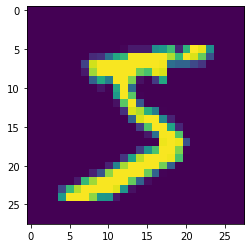

In [6]:
plt.imshow(X_train_6k[0].reshape(28,28))

In [7]:
y_train_6k[0]

5

In [0]:
#transform target output to one-hot-encoded representation
y_train_6k = tf.keras.utils.to_categorical(y_train_6k)
y_train_12k = tf.keras.utils.to_categorical(y_train_12k)
y_train_noise_6k = tf.keras.utils.to_categorical(y_train_noise_6k)
y_train_noise_12k = tf.keras.utils.to_categorical(y_train_noise_12k)

y_test = tf.keras.utils.to_categorical(y_test)

In [9]:
y_train_6k[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [2]:
#blocks definition
#input_size = 32 #ONLY FOR CIFAR DATASET

input_size = 28
def cnn_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,pooling=2):
    '''function that returns a cnn block composed of Conv-BatchNorm-ReLU-MaxPool layers'''
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x_inp)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.MaxPool2D(pool_size=(pooling,pooling))(x)
    return x


def resnet_block(x_inp, filters, kernel_size=(3, 3),padding="same", strides=1,r=True): 
    '''function that returns a cnn block composed of two BatchNorm-ReLU-Convolution layers'''
    x = K.layers.BatchNormalization()(x_inp)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation('relu')(x)
    x = K.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    if r:
        #interference Conv. layer in order to match the output dimensions
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
        x_inp = K.layers.Conv2D(filters,(1,1), padding=padding, strides=strides)(x_inp)
    x = K.layers.Add()([x,x_inp])
    return x


def resnet(k=64):
    '''ResNet network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = resnet_block(images,k,strides=1)
    n_blocks = 4
    for i in range(1, n_blocks):
            x = resnet_block(x, k* (2**i),strides=2)   
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)


def cnn(k=64):
    '''CNN network creation'''
    images = K.layers.Input((input_size,input_size, 1))
    x = cnn_block(images,k,pooling=1)
    n_blocks = 4
    for i in range(1, n_blocks):
        if i == 3:
            x = cnn_block(x, k* (2**i),pooling=4) 
            #x = cnn_block(x, k * (2**i),pooling=8) only for CIFAR DATASET   
        else:
            x = cnn_block(x, k * (2**i))
    x = K.layers.Flatten()(x)
    x = K.layers.Dense(10, activation='softmax')(x)
    net = K.models.Model(inputs=[images], outputs=[x])

    return(net)

In [3]:
net = cnn()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512   

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

In [4]:
net = resnet()
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 28, 28, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 28, 28, 1)    0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 64)   640         activation_4[0][0]               
____________________________________________________________________________________________

In [0]:
# from tensorflow.keras.utils import plot_model
# plot_model(net, to_file='model.png')

## MODEL-WISE DOUBLE DESCENT

In [13]:
train_loss_noiseless = {}
test_loss_noiseless = {}
train_loss_noise = {}
test_loss_noise = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_noiseless = []
    error_test_noiseless = []
    error_train_noise = []
    error_test_noise = []
    s = '-'
    for _ in range(3):
        #noiseless
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noiseless.append(history.history['loss'][-1])
        error_test_noiseless.append(history.history['val_loss'][-1])
        #noise
        net = cnn(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=100,validation_data=(X_test,y_test),verbose=0)
        error_train_noise.append(history.history['loss'][-1])
        error_test_noise.append(history.history['val_loss'][-1])
    train_loss_noiseless[k] = np.mean(error_train_noiseless)
    test_loss_noiseless[k] = np.mean(error_test_noiseless)
    train_loss_noise[k] = np.mean(error_train_noise)
    test_loss_noise[k] = np.mean(error_test_noise)

    if k > 1:
        if list(test_loss_noiseless.values())[-1] >= list(test_loss_noiseless.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('NOISELESS: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noiseless[k],4),round(test_loss_noiseless[k],4),s))
    if k > 1:
        if list(test_loss_noise.values())[-1] >= list(test_loss_noise.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('25% NOISE: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_noise[k],4),round(test_loss_noise[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


NOISELESS: k: 1, train_loss: 0.2183, test_loss: 0.3422 // -
25% NOISE: k: 1, train_loss: 1.2479, test_loss: 0.7111 // -


NOISELESS: k: 2, train_loss: 0.021, test_loss: 0.205 // -
25% NOISE: k: 2, train_loss: 0.9697, test_loss: 0.6068 // -


NOISELESS: k: 3, train_loss: 0.0019, test_loss: 0.1477 // -
25% NOISE: k: 3, train_loss: 0.6987, test_loss: 0.6775 // +


NOISELESS: k: 4, train_loss: 0.0006, test_loss: 0.1199 // -
25% NOISE: k: 4, train_loss: 0.3972, test_loss: 0.7988 // +


NOISELESS: k: 5, train_loss: 0.0004, test_loss: 0.1235 // +
25% NOISE: k: 5, train_loss: 0.1234, test_loss: 0.9693 // +


NOISELESS: k: 6, train_loss: 0.0003, test_loss: 0.1014 // -
25% NOISE: k: 6, train_loss: 0.032, test_loss: 0.9335 // -


NOISELESS: k: 7, train_loss: 0.0002, test_loss: 0.1061 // +
25% NOISE: k: 7, train_loss: 0.0088, test_loss: 0.8397 // -


NOISELESS: k: 8, train_loss: 0.0001, test_loss: 0.0964 // -
25% NOISE: k: 8, train_loss: 0.0038, test_loss: 0.7085 // -


NOISELESS: k: 9, train_loss

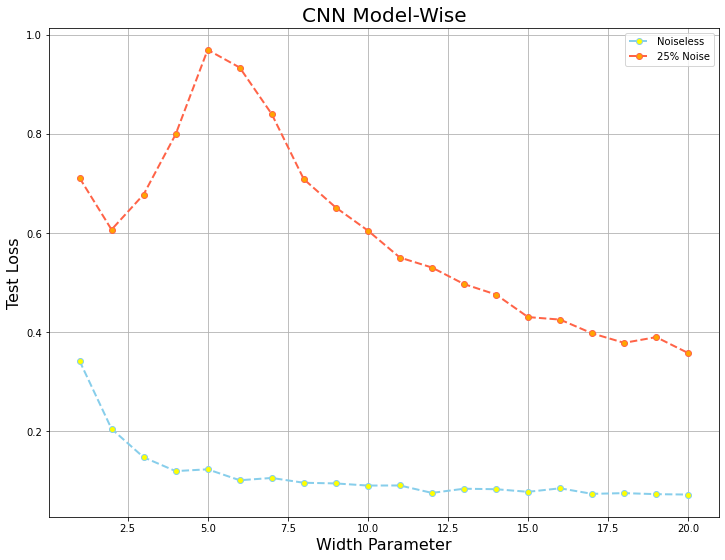

In [17]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_noiseless.keys()),list(test_loss_noiseless.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='Noiseless')
plt.plot(list(test_loss_noise.keys()),list(test_loss_noise.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='25% Noise')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## SAMLE-WISE DOUBLE DESCENT

In [19]:
train_loss_6k = {}
test_loss_6k = {}
train_loss_12k = {}
test_loss_12k = {}
for k in tqdm_notebook(range(1,21,1)):
    error_train_6k = []
    error_test_6k = []
    error_train_12k = []
    error_test_12k = []
    s = '-'
    for _ in range(3):
        #6k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_6k.append(history.history['loss'][-1])
        error_test_6k.append(history.history['val_loss'][-1])
        #12k samples
        net = resnet(k)
        net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
        history = net.fit(X_train_12k,y_train_noise_12k,batch_size=128,epochs=60,validation_data=(X_test,y_test),verbose=0)
        error_train_12k.append(history.history['loss'][-1])
        error_test_12k.append(history.history['val_loss'][-1])
    train_loss_6k[k] = np.mean(error_train_6k)
    test_loss_6k[k] = np.mean(error_test_6k)
    train_loss_12k[k] = np.mean(error_train_12k)
    test_loss_12k[k] = np.mean(error_test_12k)

    if k > 1:
        if list(test_loss_6k.values())[-1] >= list(test_loss_6k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('6k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_6k[k],4),round(test_loss_6k[k],4),s))
    if k > 1:
        if list(test_loss_12k.values())[-1] >= list(test_loss_12k.values())[-2]:
            s = '+'
        else:
            s = '-'
    print('12k SAMPLES: k: {}, train_loss: {}, test_loss: {} // {}'.format(k,round(train_loss_12k[k],4),round(test_loss_12k[k],4),s))
    print()
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


6k SAMPLES: k: 1, train_loss: 1.1909, test_loss: 0.6954 // -
12k SAMPLES: k: 1, train_loss: 1.2336, test_loss: 0.6522 // -


6k SAMPLES: k: 2, train_loss: 0.9735, test_loss: 0.6037 // -
12k SAMPLES: k: 2, train_loss: 1.0519, test_loss: 0.5006 // -


6k SAMPLES: k: 3, train_loss: 0.735, test_loss: 0.7096 // +
12k SAMPLES: k: 3, train_loss: 0.9162, test_loss: 0.5247 // +


6k SAMPLES: k: 4, train_loss: 0.3214, test_loss: 1.2316 // +
12k SAMPLES: k: 4, train_loss: 0.7196, test_loss: 0.6841 // +


6k SAMPLES: k: 5, train_loss: 0.15, test_loss: 1.6702 // +
12k SAMPLES: k: 5, train_loss: 0.515, test_loss: 0.9023 // +


6k SAMPLES: k: 6, train_loss: 0.0845, test_loss: 1.6459 // -
12k SAMPLES: k: 6, train_loss: 0.3006, test_loss: 1.1831 // +


6k SAMPLES: k: 7, train_loss: 0.0083, test_loss: 1.5057 // -
12k SAMPLES: k: 7, train_loss: 0.1703, test_loss: 1.5486 // +


6k SAMPLES: k: 8, train_loss: 0.0015, test_loss: 1.5599 // +
12k SAMPLES: k: 8, train_loss: 0.1381, test_loss: 1.4593 // -


6k S

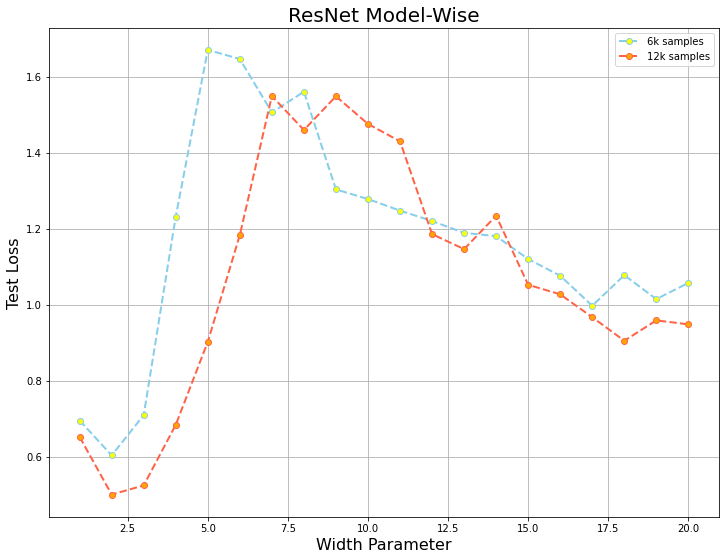

In [20]:
# multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss_6k.keys()),list(test_loss_6k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='6k samples')
plt.plot(list(test_loss_12k.keys()),list(test_loss_12k.values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='12k samples')
plt.xlabel('Width Parameter',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Model-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

## EPOCH-WISE DOUBLE DESCENT

### CNN

In [26]:
train_loss = {}
test_loss = {}
for k in [3,12,48]:
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,155,5)):
        error_train = []
        error_test = []
        s = '-'
        for _ in range(3):
            net = cnn(k)
            net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
            history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
            error_train.append(history.history['loss'][-1])
            error_test.append(history.history['val_loss'][-1])
        train_loss[k][e] = np.mean(error_train)
        test_loss[k][e] = np.mean(error_test)
        if e > 5:
            if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
                s = '+'
            else:
                s = '-'
        print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[k][e],4),round(test_loss[k][e],4),s))

Model width parameter k: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Epoch: 5, train_loss: 1.2943, test_loss: 1.6759 // -
Epoch: 10, train_loss: 1.1458, test_loss: 0.7988 // -
Epoch: 15, train_loss: 1.0882, test_loss: 0.6623 // -
Epoch: 20, train_loss: 1.0405, test_loss: 0.5976 // -
Epoch: 25, train_loss: 0.9864, test_loss: 0.6139 // +
Epoch: 30, train_loss: 0.9597, test_loss: 0.6155 // +
Epoch: 35, train_loss: 0.9345, test_loss: 0.6078 // -
Epoch: 40, train_loss: 0.9053, test_loss: 0.5772 // -
Epoch: 45, train_loss: 0.8852, test_loss: 0.6009 // +
Epoch: 50, train_loss: 0.8665, test_loss: 0.553 // -
Epoch: 55, train_loss: 0.8393, test_loss: 0.6526 // +
Epoch: 60, train_loss: 0.8354, test_loss: 0.5811 // -
Epoch: 65, train_loss: 0.7835, test_loss: 0.6511 // +
Epoch: 70, train_loss: 0.7766, test_loss: 0.6612 // +
Epoch: 75, train_loss: 0.7658, test_loss: 0.6626 // +
Epoch: 80, train_loss: 0.7447, test_loss: 0.6023 // -
Epoch: 85, train_loss: 0.7604, test_loss: 0.6347 // +
Epoch: 90, train_loss: 0.7471, test_loss: 0.6558 // +
Epoch: 95, train_loss: 0.7391,

Epoch: 5, train_loss: 0.9763, test_loss: 2.5746 // -
Epoch: 10, train_loss: 0.6764, test_loss: 1.127 // -
Epoch: 15, train_loss: 0.3819, test_loss: 0.7559 // -
Epoch: 20, train_loss: 0.1508, test_loss: 0.5816 // -
Epoch: 25, train_loss: 0.0696, test_loss: 0.5578 // -
Epoch: 30, train_loss: 0.0277, test_loss: 0.5131 // -
Epoch: 35, train_loss: 0.0161, test_loss: 0.506 // -
Epoch: 40, train_loss: 0.0115, test_loss: 0.4781 // -
Epoch: 45, train_loss: 0.0082, test_loss: 0.488 // +
Epoch: 50, train_loss: 0.006, test_loss: 0.4758 // -
Epoch: 55, train_loss: 0.005, test_loss: 0.4597 // -
Epoch: 60, train_loss: 0.0039, test_loss: 0.5043 // +
Epoch: 65, train_loss: 0.0032, test_loss: 0.4616 // -
Epoch: 70, train_loss: 0.0027, test_loss: 0.5236 // +
Epoch: 75, train_loss: 0.0021, test_loss: 0.4667 // -
Epoch: 80, train_loss: 0.0015, test_loss: 0.5018 // +
Epoch: 85, train_loss: 0.0014, test_loss: 0.5224 // +
Epoch: 90, train_loss: 0.0013, test_loss: 0.511 // -
Epoch: 95, train_loss: 0.0011, test

Epoch: 5, train_loss: 0.9491, test_loss: 3.9769 // -
Epoch: 10, train_loss: 0.3358, test_loss: 2.4671 // -
Epoch: 15, train_loss: 0.032, test_loss: 0.7334 // -
Epoch: 20, train_loss: 0.0026, test_loss: 0.2849 // -
Epoch: 25, train_loss: 0.0015, test_loss: 0.2621 // -
Epoch: 30, train_loss: 0.001, test_loss: 0.2632 // +
Epoch: 35, train_loss: 0.0008, test_loss: 0.2888 // +
Epoch: 40, train_loss: 0.0006, test_loss: 0.2866 // -
Epoch: 45, train_loss: 0.0004, test_loss: 0.263 // -
Epoch: 50, train_loss: 0.0003, test_loss: 0.2573 // -
Epoch: 55, train_loss: 0.0003, test_loss: 0.2776 // +
Epoch: 60, train_loss: 0.0002, test_loss: 0.2596 // -
Epoch: 65, train_loss: 0.0002, test_loss: 0.2713 // +
Epoch: 70, train_loss: 0.0002, test_loss: 0.2817 // +
Epoch: 75, train_loss: 0.0001, test_loss: 0.2685 // -
Epoch: 80, train_loss: 0.0001, test_loss: 0.2747 // +
Epoch: 85, train_loss: 0.0001, test_loss: 0.2817 // +
Epoch: 90, train_loss: 0.0001, test_loss: 0.2549 // -
Epoch: 95, train_loss: 0.0001, t

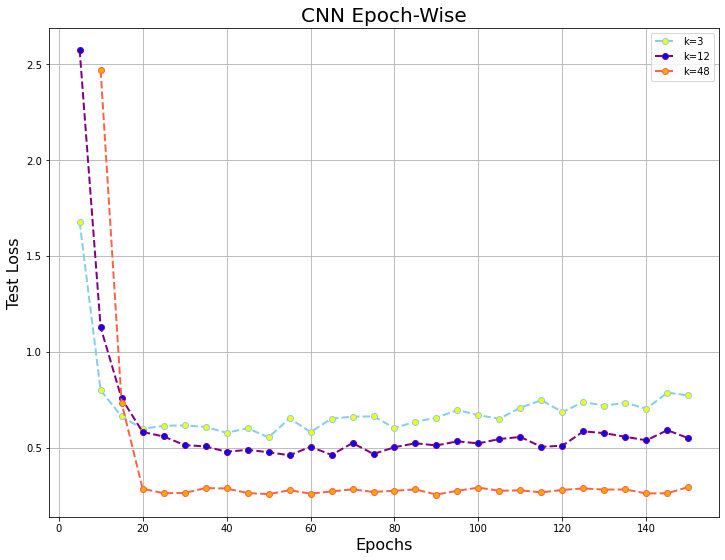

In [27]:
#multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss[3].keys()),list(test_loss[3].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='k=3')
plt.plot(list(test_loss[12].keys()),list(test_loss[12].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='blue', color='purple', linewidth=2,markersize=12,label='k=12')
plt.plot(list(test_loss[48].keys())[1:],list(test_loss[48].values())[1:],'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('CNN Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()

### ResNet

In [28]:
train_loss = {}
test_loss = {}
for k in [3,12,48]:
    print('Model width parameter k: {}'.format(k))
    train_loss[k] = {}
    test_loss[k] = {}
    for e in tqdm_notebook(range(5,105,5)):
        error_train = []
        error_test = []
        s = '-'
        for _ in range(3):
            net = resnet(k)
            net.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(0.001),metrics=metrics.categorical_accuracy)
            history = net.fit(X_train_6k,y_train_noise_6k,batch_size=128,epochs=e,validation_data=(X_test,y_test),verbose=0)
            error_train.append(history.history['loss'][-1])
            error_test.append(history.history['val_loss'][-1])
        train_loss[k][e] = np.mean(error_train)
        test_loss[k][e] = np.mean(error_test)
        if e > 5:
            if list(test_loss[k].values())[-1] >= list(test_loss[k].values())[-2]:
                s = '+'
            else:
                s = '-'
        print('Epoch: {}, train_loss: {}, test_loss: {} // {}'.format(e,round(train_loss[k][e],4),round(test_loss[k][e],4),s))

Model width parameter k: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Epoch: 5, train_loss: 1.2472, test_loss: 1.2441 // -
Epoch: 10, train_loss: 1.1177, test_loss: 0.7158 // -
Epoch: 15, train_loss: 1.038, test_loss: 0.6074 // -
Epoch: 20, train_loss: 0.9783, test_loss: 0.571 // -
Epoch: 25, train_loss: 0.9332, test_loss: 0.5702 // -
Epoch: 30, train_loss: 0.8935, test_loss: 0.5884 // +
Epoch: 35, train_loss: 0.8654, test_loss: 0.6212 // +
Epoch: 40, train_loss: 0.8136, test_loss: 0.668 // +
Epoch: 45, train_loss: 0.7984, test_loss: 0.6493 // -
Epoch: 50, train_loss: 0.7644, test_loss: 0.6508 // +
Epoch: 55, train_loss: 0.7297, test_loss: 0.7633 // +
Epoch: 60, train_loss: 0.7131, test_loss: 0.7455 // -
Epoch: 65, train_loss: 0.6978, test_loss: 0.7179 // -
Epoch: 70, train_loss: 0.6734, test_loss: 0.8577 // +
Epoch: 75, train_loss: 0.6737, test_loss: 0.816 // -
Epoch: 80, train_loss: 0.6275, test_loss: 0.896 // +
Epoch: 85, train_loss: 0.6028, test_loss: 0.9214 // +
Epoch: 90, train_loss: 0.5823, test_loss: 0.9694 // +
Epoch: 95, train_loss: 0.5939, tes

Epoch: 5, train_loss: 0.9094, test_loss: 1.4696 // -
Epoch: 10, train_loss: 0.3411, test_loss: 0.8916 // -
Epoch: 15, train_loss: 0.0835, test_loss: 1.1364 // +
Epoch: 20, train_loss: 0.0976, test_loss: 1.3324 // +
Epoch: 25, train_loss: 0.0405, test_loss: 1.2594 // -
Epoch: 30, train_loss: 0.0035, test_loss: 1.2348 // -
Epoch: 35, train_loss: 0.0007, test_loss: 1.1863 // -
Epoch: 40, train_loss: 0.0005, test_loss: 1.191 // +
Epoch: 45, train_loss: 0.0004, test_loss: 1.2124 // +
Epoch: 50, train_loss: 0.0003, test_loss: 1.1656 // -
Epoch: 55, train_loss: 0.0002, test_loss: 1.2477 // +
Epoch: 60, train_loss: 0.0002, test_loss: 1.1951 // -
Epoch: 65, train_loss: 0.0002, test_loss: 1.2814 // +
Epoch: 70, train_loss: 0.0001, test_loss: 1.3713 // +
Epoch: 75, train_loss: 0.0001, test_loss: 1.2634 // -
Epoch: 80, train_loss: 0.0001, test_loss: 1.2798 // +
Epoch: 85, train_loss: 0.0001, test_loss: 1.3579 // +
Epoch: 90, train_loss: 0.0001, test_loss: 1.2855 // -
Epoch: 95, train_loss: 0.0001,

Epoch: 5, train_loss: 0.7564, test_loss: 2.4205 // -
Epoch: 10, train_loss: 0.1846, test_loss: 1.096 // -
Epoch: 15, train_loss: 0.0927, test_loss: 1.3636 // +
Epoch: 20, train_loss: 0.0768, test_loss: 1.2484 // -
Epoch: 25, train_loss: 0.093, test_loss: 1.354 // +
Epoch: 30, train_loss: 0.0442, test_loss: 1.3945 // +
Epoch: 35, train_loss: 0.0146, test_loss: 1.1163 // -
Epoch: 40, train_loss: 0.0239, test_loss: 1.2028 // +
Epoch: 45, train_loss: 0.0045, test_loss: 1.0216 // -
Epoch: 50, train_loss: 0.0002, test_loss: 1.1175 // +
Epoch: 55, train_loss: 0.0, test_loss: 1.1588 // +
Epoch: 60, train_loss: 0.0062, test_loss: 1.1303 // -
Epoch: 65, train_loss: 0.0, test_loss: 1.1397 // +
Epoch: 70, train_loss: 0.0, test_loss: 1.0121 // -
Epoch: 75, train_loss: 0.0, test_loss: 1.0566 // +
Epoch: 80, train_loss: 0.0, test_loss: 1.1211 // +
Epoch: 85, train_loss: 0.0, test_loss: 1.076 // -
Epoch: 90, train_loss: 0.0, test_loss: 1.0739 // -
Epoch: 95, train_loss: 0.0, test_loss: 1.0704 // -
Epo

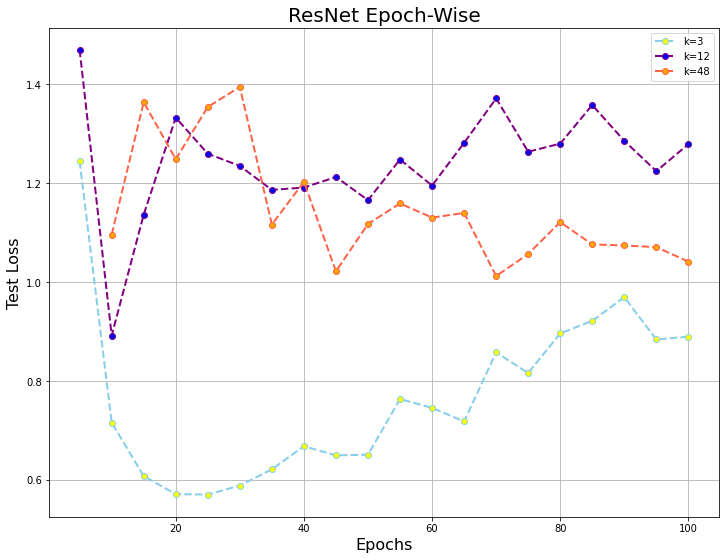

In [29]:
#multiple line plot
plt.figure(figsize=(12,9))
plt.plot(list(test_loss[3].keys()),list(test_loss[3].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='yellow', color='skyblue', linewidth=2,markersize=12,label='k=3')
plt.plot(list(test_loss[12].keys()),list(test_loss[12].values()),'bx-',marker = '.',linestyle='--', 
         markerfacecolor='blue', color='purple', linewidth=2,markersize=12,label='k=12')
plt.plot(list(test_loss[48].keys())[1:],list(test_loss[48].values())[1:],'bx-',marker = '.',linestyle='--', 
         markerfacecolor='orange', color='tomato', linewidth=2,markersize=12,label='k=48')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Test Loss',fontsize=16)
plt.title('ResNet Epoch-Wise',fontsize=20)
plt.legend()
plt.grid()
plt.show()